## ***Jupyter Notebook to accompany the paper:***
    
# ***A data-driven framework for Paleomagnetic Euler Pole analysis - Least squares optimization for small circle fitting - or - or***

### ***by L. C. Gallo$^1$*** *(l.c.gallo@geo.uio.no)* ***F. Sapienza$^2$ and M. Domeier$^1$***

*$^1$Centre for Earth Evolution and Dynamics, University of Oslo, Norway.*

*$^2$Department of Statistics, University of California Berkeley, United States.*

**VERSION 1.0 (3 October 2021)**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.sparse.csgraph import shortest_path, dijkstra

from auxiliar.utils import cartesian2spherical, spherical2cartesian, GCD_cartesian, StageEP

np.random.seed(1) #seed for reproducibility

### REMEMBER TO RESTART THE KERNEL

We start by generating stochastic models of the drift of a plate by randomly generating stage Euler vectors -represented in the matrix form as $R(q,\omega)$- which remain constant during a temporal stage of duration $t$. The geographic coordinates of the Euler pole $(\phi_{q},\theta_{q})$ during each stage are randomly selected on the unit sphere. Angular velocities $\omega$ are chosen from a uniform distribution and constrained to between 0.1$^{\circ}$/Myr and 2.5$^{\circ}$/Myr, which yields plate velocities up to ~28 cm/yr.

#### Set up of the parameters for the simulation of an APWP:

In [2]:
N = 200                       #number of paleomagnetic poles

t_min = 15                    # minimum stage duration
t_max = 25                    # maximum stage duration

omega_min = np.radians(0.6)   # Minimum angular velocity
omega_max = np.radians(2.5)   # Maximum angular velocity

Populates the APWP:

In [3]:
APWP = [] # list for storing the sequential PPs (cartesian coordinates) 

pp = spherical2cartesian([np.radians(-90), 0]) #setting the geographic pole as the first paleomagnetic pole

#APWP.append(np.array(geographic_pole))
age, changepoints, omegas, EPs = [], [], [], []

i = 0

sigma = np.radians(0.05)# 0.003 # low noise intensity
#sigma_noise = 0.005

while i < N:
    
    changepoint = i + np.random.randint(t_min, t_max + 1)
    changepoint_tmp = True
    
    #set new angular velocity
    w = np.random.uniform(omega_min, omega_max)
    
    #set random euler pole
    rand_i, rand_j = np.random.rand(2)           # Two independent random numbers from a uniform distribution in the range (0, 1)
    [lat,long] = [2 * np.pi * rand_i, np.arcsin(rand_j * 2 - 1)]         # Spherical coordinate theta
    ep = spherical2cartesian([lat, long])
     
    #rotation matrix defined defined by parameters ep coordinates and omega
    r = rotation.from_rotvec(w * np.array(ep))
    
    while i < changepoint and i < N:        
        
        pp = r.apply(np.array(pp))  
    
        # Add noise to the PP
        
        pp = cartesian2spherical(pp)
        pp += np.random.normal(0, sigma, 2)
        pp = spherical2cartesian(pp)
        
#         pp += np.random.normal(0, sigma_noise, 3) 
#         pp /= np.linalg.norm(pp)
        
        age.append(i)
        EPs.append(ep)
        APWP.append(pp)
        omegas.append(w)
        changepoints.append(changepoint_tmp)
        changepoint_tmp = False
        
        i += 1

Generate and store in Pandas DataFrame for visualization purposes:

In [4]:
dictionary = {'i' : age,
              'PP_x': [i[0] for i in APWP],
              'PP_y': [i[1] for i in APWP],
              'PP_z': [i[2] for i in APWP],
              'changepoint': changepoints, 
              'EP_x': [i[0] for i in EPs],
              'EP_y': [i[1] for i in EPs],
              'EP_z': [i[2] for i in EPs],
              'omega': omegas}

apwp_df = pd.DataFrame(dictionary)

apwp_df[apwp_df['changepoint'] == True]

,i,PP_x,PP_y,PP_z,changepoint,EP_x,EP_y,EP_z,omega
0,0,0.028732,0.025296,-0.999267,True,0.609333,-0.677967,-0.411186,0.043540
20,20,0.599496,0.375945,-0.706591,True,-0.097513,0.001644,0.995233,0.017490
41,41,0.452617,0.527300,-0.719091,True,0.091365,-0.005971,-0.995800,0.026079
57,57,0.614643,0.345622,-0.709055,True,0.714524,0.487911,-0.501397,0.041550
82,82,0.494232,0.582117,-0.645658,True,0.660896,0.007485,0.750440,0.014661
104,104,0.330947,0.811354,-0.481849,True,0.987436,0.062666,0.145060,0.018438
121,121,0.302343,0.920533,-0.247402,True,-0.628876,0.395808,-0.669217,0.024262
140,140,0.467243,0.692157,-0.550094,True,-0.890780,0.446754,0.083202,0.019422
158,158,0.358727,0.489982,-0.794501,True,-0.784631,-0.598256,0.162613,0.026325
182,182,0.611814,0.189604,-0.767941,True,0.495520,-0.060498,0.866487,0.042079


#### Visualization of the synhetic EPs and associated APWP

In [5]:
list_apwp = apwp_df[['PP_x','PP_y','PP_z']].values.tolist()
APWP_LatLong = np.array([cartesian2spherical(i) for i in list_apwp]) # Convert to sphercial coordinates

list_eps = apwp_df[['EP_x','EP_y','EP_z']].values.tolist()
EPs_lowerH = [np.array(i) if i[2] < 0 else -np.array(i) for i in list_eps] #converts to lower hemisphere for visualization purpose only
EPs_LatLong = np.array([cartesian2spherical(i) for i in EPs_lowerH])

change_points_df = apwp_df[apwp_df['changepoint'] == True]
list_changepoints = change_points_df[['PP_x','PP_y','PP_z']].values.tolist()
changepoints_latlong = np.array([cartesian2spherical(i) for i in list_changepoints])

In [9]:
fig = plt.figure(figsize=(10,10))

proj = ccrs.Orthographic(-30, -60)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

ax.scatter(x = np.degrees(APWP_LatLong[:,1]), y = np.degrees(APWP_LatLong[:,0]),
           c = np.array(range(len(APWP_LatLong))), cmap="plasma", 
           Label = "Synthetic APWP", edgecolors='black',
           transform=ccrs.PlateCarree())

ax.scatter(x = np.degrees(EPs_LatLong[:,1]), y = np.degrees(EPs_LatLong[:,0]),
           c = np.array(range(len(APWP_LatLong))), cmap="plasma", 
           Label = "Synthetic Euler Poles", edgecolors='black', marker ="*", s = 50,
           transform=ccrs.PlateCarree())

ax.scatter(x = np.degrees(changepoints_latlong[:,1]), y = np.degrees(changepoints_latlong[:,0]),
            
           Label = "Changepoints", marker ="*", s = 50, color = "white" ,
           transform=ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

plt.show()

NameError: name 'ccrs' is not defined

<Figure size 720x720 with 0 Axes>

## Computing the adj matrix
Takes up to 20 minutes (for 200 PPs)

In [6]:
%%time
n_min = 3
n_max = 150

Adj_matrix = np.full((N, N), np.inf)
matrix_eps = np.full((N, N), np.inf, dtype=object)

for i in range(N):
    
    for j in range(i + n_min, i + n_max + 1):
        
        if j >= N:
            continue
            
        # We need to define the loss function from zero since it has the PP inside the function        
        X = apwp_df[i:j+1][['PP_x', 'PP_y', 'PP_z']].to_numpy()
                        
        # If the first and last point are too close in relation to the other points of the segments, this indicates
        # the presence two different EPs with overlapping segments moving in opposite directions
        pp_i, pp_f = X[0], X[-1]
        # do this with geodesic distance! 
        
        path_distance = GCD_cartesian(pp_i, pp_f)
        max_dist = np.max([GCD_cartesian(X[k], X[m]) for m in range(X.shape[0]) for k in range(m+1,X.shape[0])])
        if path_distance < 0.8 * max_dist:
            continue
             
        def loss (v):
            theta, phi, varphi = v[0], v[1], v[2]                   
            res = 0
            pole = spherical2cartesian([theta, phi])
            for k in range(X.shape[0]):
                res += ( np.arccos( np.dot( X[k,:], pole)) - varphi ) ** 2        
            return res
        
        
        initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(-np.pi/2, np.pi / 2)] #set up random initial guess        
        best = np.inf        
        for _ in range(1): #number of iterations
            
            optimum_tmp = minimize(loss, x0 = np.array(initialGuess), method = "CG", options = {'gtol': 1E-10})
            
            initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(-np.pi/2, np.pi / 2)]           
            
            if optimum_tmp.fun < best: 
                optimum = optimum_tmp
                best = optimum_tmp.fun
                #initialGuess = [optimum_tmp.x[0], optimum_tmp.x[1], optimum_tmp.x[2]]
                
        Adj_matrix[i,j] = optimum.fun
        matrix_eps[i,j] = spherical2cartesian([optimum.x[0], optimum.x[1]])

CPU times: user 2h 57min 2s, sys: 2.55 s, total: 2h 57min 4s
Wall time: 4h 59min 18s


#### Visualizing the Adjacency matrix 

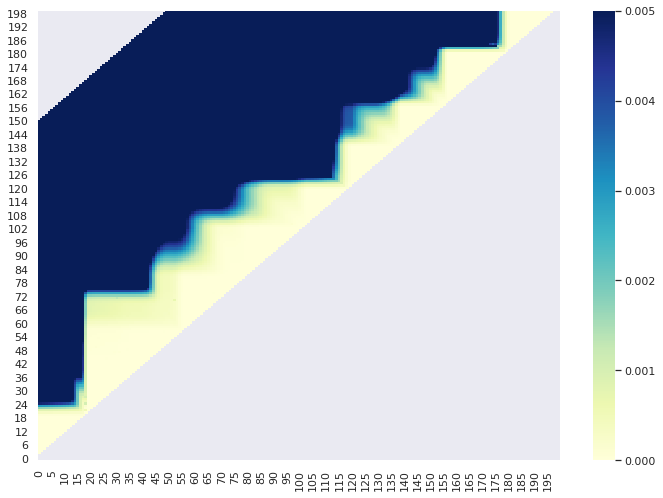

In [7]:
from matplotlib.colors import LogNorm
Adj_matrix_df = pd.DataFrame(Adj_matrix.transpose())
# Adj_matrix_df.to_csv('Adj_matrix.csv')
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Default heatmap
sns.heatmap(Adj_matrix_df, vmin=0, vmax=0.005, cmap="YlGnBu", robust=True).invert_yaxis()

#### We then proceed to calculate the APWP changepoints from the shortest path

In [8]:
def get_changepoints(Adj_matrix, reg = 0.0001):
    '''
    Given the Adjacency matrix and the regularization parameter, returns a list with changepoints along with the distance matrix
    '''    
    
    dist_matrix, predecesors = shortest_path(Adj_matrix + reg, 
                                             return_predecessors = True)
    
    res = []
    x = predecesors[0, -1]
    
    while x != 0:
        
        res.append(x)
        x = predecesors[0, x]
        
    return list(reversed(res)), dist_matrix 

#### Visualizing the total cost as a function of the regularization paramenter in order to achieve an unsupervised estimation

In [9]:
all_lamb_log = np.linspace(-6, 0, 1000)
all_lamb = 10 ** all_lamb_log

all_cost, all_nsegments = [], []

for lamb in all_lamb:    
    
    changepoints, dist_matrix = get_changepoints(Adj_matrix, reg=lamb)
    
    loss_reg = lamb * len(changepoints)
    loss = dist_matrix[0,-1]
    loss1 = loss - loss_reg
    
    all_nsegments.append(len(changepoints))
    all_cost.append(loss)

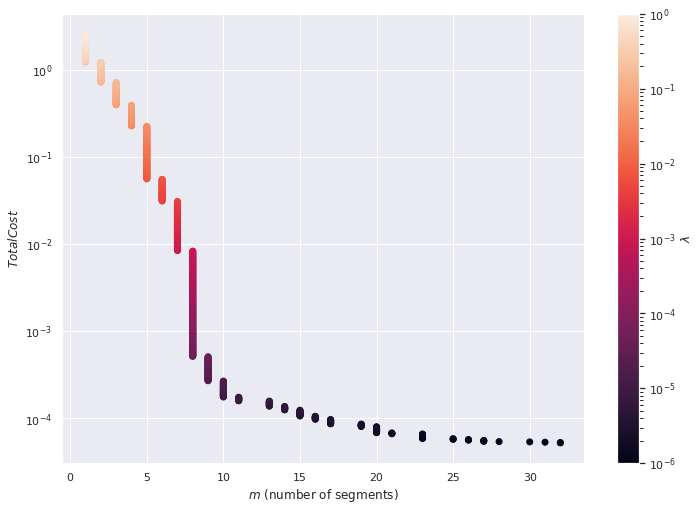

In [16]:
from matplotlib.colors import LogNorm

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(all_nsegments,all_cost,c=all_lamb, norm=LogNorm())
plt.ylabel('$Total Cost$', size = 12)
plt.xlabel('$m$ (number of segments)', size = 12)
#plt.ylim(0,.001)
plt.yscale('log')
plt.colorbar(label = '$\lambda$')
plt.savefig('elbow.pdf', dpi =600)
plt.show()


In [237]:
# now, we pick the value of lambda for which we observe the elbow in the plot
lamb_opt = all_lamb[np.max(np.where(np.array(all_nsegments) == 11))]

changepoints, dist_matrix = get_changepoints(Adj_matrix, reg=0.001)
changepoints, lamb_opt

([19, 41, 56, 81, 103, 120, 139, 157, 181, 214], 0.0002782559402207126)

In [238]:
apwp_df[apwp_df['changepoint'] == True]

,i,PP_x,PP_y,PP_z,changepoint,EP_x,EP_y,EP_z,omega
0,0,0.028732,0.025296,-0.999267,True,0.609333,-0.677967,-0.411186,0.043540
20,20,0.599496,0.375945,-0.706591,True,-0.097513,0.001644,0.995233,0.017490
41,41,0.452617,0.527300,-0.719091,True,0.091365,-0.005971,-0.995800,0.026079
57,57,0.614643,0.345622,-0.709055,True,0.714524,0.487911,-0.501397,0.041550
82,82,0.494232,0.582117,-0.645658,True,0.660896,0.007485,0.750440,0.014661
104,104,0.330947,0.811354,-0.481849,True,0.987436,0.062666,0.145060,0.018438
121,121,0.302343,0.920533,-0.247402,True,-0.628876,0.395808,-0.669217,0.024262
140,140,0.467243,0.692157,-0.550094,True,-0.890780,0.446754,0.083202,0.019422
158,158,0.358727,0.489982,-0.794501,True,-0.784631,-0.598256,0.162613,0.026325
182,182,0.611814,0.189604,-0.767941,True,0.495520,-0.060498,0.866487,0.042079


#### Function that generates a DataFrame in which we put the inversion parameters

In [239]:
def EPdf(APWP, matrix_eps, changepoints):
    '''Creates a DataFrame with the inverted EPs
    input: APWP is a list of cartesian coordinates, 
    matrix_eps is the matrix with the inverted Euler Poles (matrix_eps[i:j] is the
    inverted EP for the segment ti - tj).
    
    output: Dataframe with cartesian coordinates of the inverted euler poles for each 1-Myr step'''
    EPs = []
    omegas = []
    tmp = 0
    
    for i in range(len(matrix_eps)):                          
        
        if i <= changepoints[0]:
            #print(i,[0, changepoints[tmp]])
            EP = matrix_eps[0, changepoints[tmp]]
            omega = StageEP(EP, APWP[0:changepoints[tmp]]) / len(APWP[0:changepoints[tmp]])
        elif i >= changepoints[-1]:
            #print(i,[changepoints[-1], len(matrix_eps)-1])
            EP = matrix_eps[changepoints[-1], len(matrix_eps)-1]
            omega = StageEP(EP, APWP[changepoints[-1]: len(matrix_eps)-1]) / len(APWP[changepoints[-1]: len(matrix_eps)-1])
        else:
            #print(i,[changepoints[tmp], changepoints[tmp+1]])
            EP = matrix_eps[changepoints[tmp], changepoints[tmp+1]]
            omega = StageEP(EP, APWP[changepoints[tmp]: changepoints[tmp+1]]) / len(APWP[changepoints[tmp]: changepoints[tmp+1]])
            if (i) > (changepoints[tmp + 1]-1): tmp += 1 
                
        EPs.append(EP)
        omegas.append(omega)
    
    EPs = np.array(EPs)
    omegas = np.array(omegas)
    
    dictionary = { 'EP_x_inv': EPs[:,0],
                   'EP_y_inv': EPs[:,1],
                   'EP_z_inv': EPs[:,2],
                   'omega_inv': omegas,
                  }
    
    df = pd.DataFrame(dictionary)            
       
    return df                                                         

### Creating the DataFrame for the inversion

In [240]:
apwp_complete = apwp_df
EP_inversion = EPdf(APWP, matrix_eps, changepoints)
apwp_complete = apwp_complete.join(EP_inversion)

#### Function that measures the discrepancy of points at a given latitude, after rotating with the whole sequence of inverted poles

In [241]:
def points_misfit(apwp_complete, lat):
    
    GCD_list = []
    for _,i in apwp_complete.iterrows():
        
        if _ == 0: point, point_inv = spherical2cartesian([lat, 0]), spherical2cartesian([lat, 0])
              
        r = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))
        r_inv = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))

        point = r.apply(np.array(point))
        point_inv = r_inv.apply(np.array(point_inv))
        
        GCD_list.append(GCD_cartesian(point, point_inv))
    
    apwp_complete['Point' + str(np.round(np.degrees(lat),0).astype(int))] = GCD_list
    
    return apwp_complete

In [242]:
GCD_list = []

for _,i in apwp_complete.iterrows():

    if _ == 0: point, point_inv = spherical2cartesian([lat, 0]), spherical2cartesian([lat, 0])

    r = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))
    r_inv = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))

    point = r.apply(np.array(point))
    point_inv = r_inv.apply(np.array(point_inv))

    GCD_list.append(GCD_cartesian(point, point_inv))

### Misfit between an APWP and the one we obtained from the inversion of EPs

In [243]:
def apwp_misfit(apwp_complete):
    
    PP_x, PP_y, PP_z = [], [], []

    for _,i in apwp_complete.iterrows():

        if _ == 0: pp = [0,0,-1]  

        r = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))  
        pp = r.apply(np.array(pp))   
        pp_x, pp_y, pp_z = pp[0], pp[1], pp[2]    
        PP_x.append(pp_x) 
        PP_y.append(pp_y) 
        PP_z.append(pp_z) 

    apwp_complete['PP_x_inv'] = PP_x    
    apwp_complete['PP_y_inv'] = PP_y   
    apwp_complete['PP_z_inv'] = PP_z   
    apwp_complete['PPs_Misfit'] = [GCD_cartesian([i.PP_x, i.PP_y, i.PP_z],[i.PP_x_inv, i.PP_y_inv, i.PP_z_inv]) for _,i in apwp_complete.iterrows()]
    
    return apwp_complete

### Calculates the total reconstruction pole for each time (known)

In [244]:
def total_rotation_poles(apwp_complete):
    
    TR_x, TR_y, TR_z, TR_omega = [], [], [], []
    TR_x_inv, TR_y_inv, TR_z_inv, TR_omega_inv = [], [], [], []
        
    for _,i in apwp_complete.iterrows():   
        if _ == 0: 
            ep = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))                    
            TR_omega.append(ep.magnitude())
            TR_x.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
        else:
            ep_tmp = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))
            ep = rotation.from_matrix(np.dot(ep_tmp.as_matrix(), ep.as_matrix()))
            TR_omega.append(ep.magnitude())  
            TR_x.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
            
    apwp_complete['TR_x'] = TR_x
    apwp_complete['TR_y'] = TR_y
    apwp_complete['TR_z'] = TR_z
    apwp_complete['TR_omega'] = TR_omega
    
    return apwp_complete

In [245]:
def total_rotation_poles_inv(apwp_complete):
        
    TR_x_inv, TR_y_inv, TR_z_inv, TR_omega_inv = [], [], [], []
        
    for _,i in apwp_complete.iterrows():   
        if _ == 0: 
            ep = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))                    
            TR_omega_inv.append(ep.magnitude())
            TR_x_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
        else:
            ep_tmp = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))
            ep = rotation.from_matrix(np.dot(ep_tmp.as_matrix(),ep.as_matrix()))
            TR_omega_inv.append(ep.magnitude())
            TR_x_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
            
    apwp_complete['TR_x_inv'] = TR_x_inv
    apwp_complete['TR_y_inv'] = TR_y_inv
    apwp_complete['TR_z_inv'] = TR_z_inv
    apwp_complete['TR_omega_inv'] = TR_omega_inv
    
    return apwp_complete

#### Comparison of true kinematics with those inferred from the proposed methodoly. 
- Euler-pole misfit represents the geodesic distance between Euler poles associated with true and inferred stage Euler vectors.
- angular-velocity misfit if the difference between angular velocities of true and inferred stage Euler vectors

In [246]:
apwp_complete['EP_Misfit'] = [GCD_cartesian([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv],[i.EP_x, i.EP_y, i.EP_z]) for _,i in apwp_complete.iterrows()]
apwp_complete['AngVel_Misfit'] = [(np.abs(i.omega) - np.abs(i.omega_inv)) for _,i in apwp_complete.iterrows()]
apwp_complete['EP_Misfit_corr'] = [(np.pi - i.EP_Misfit) if i.EP_Misfit > (np.pi / 2) else i.EP_Misfit for _,i in apwp_complete.iterrows()]
#apwp_complete[25:40]

In [247]:
lats = [0,20,40,60,80]

for i in np.radians(lats):
    apwp_complete = points_misfit(apwp_complete, i)

In [248]:
apwp_complete = apwp_misfit(apwp_complete)

In [249]:
apwp_complete = total_rotation_poles(apwp_complete)
apwp_complete = total_rotation_poles_inv(apwp_complete)

In [250]:
apwp_complete['TR_Misfit'] = [GCD_cartesian([i.TR_x_inv, i.TR_y_inv, i.TR_z_inv],[i.TR_x, i.TR_y, i.TR_z]) for _,i in apwp_complete.iterrows()]
apwp_complete['TR_Ang_Misfit'] = [(i.TR_omega - i.TR_omega_inv) for _,i in apwp_complete.iterrows()]

In [251]:
apwp_complete.columns

Index(['i', 'PP_x', 'PP_y', 'PP_z', 'changepoint', 'EP_x', 'EP_y', 'EP_z',
       'omega', 'EP_x_inv', 'EP_y_inv', 'EP_z_inv', 'omega_inv', 'EP_Misfit',
       'AngVel_Misfit', 'EP_Misfit_corr', 'Point0', 'Point20', 'Point40',
       'Point60', 'Point80', 'PP_x_inv', 'PP_y_inv', 'PP_z_inv', 'PPs_Misfit',
       'TR_x', 'TR_y', 'TR_z', 'TR_omega', 'TR_x_inv', 'TR_y_inv', 'TR_z_inv',
       'TR_omega_inv', 'TR_Misfit', 'TR_Ang_Misfit'],
      dtype='object')

### Statistics for the comparison of true kinematics with those inferred

First, we plot the geodetic distantce between the known and the inferred EP position

<AxesSubplot:ylabel='EP_Misfit_corr'>

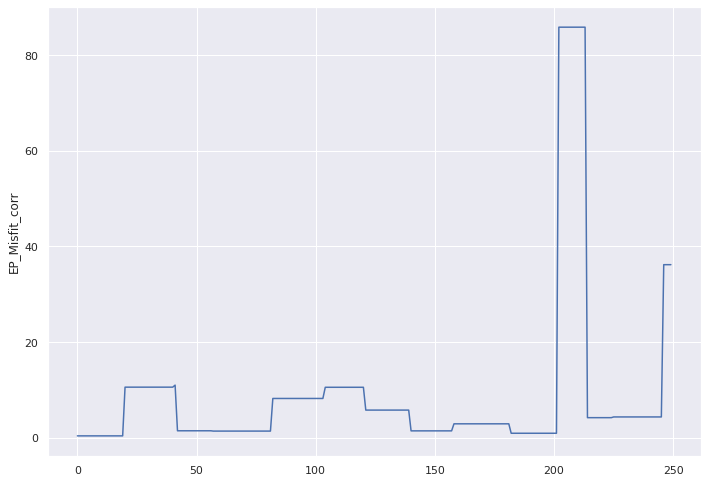

In [252]:
sns.lineplot( x = apwp_complete.index, y = apwp_complete['EP_Misfit_corr'] * 180 / np.pi)

<AxesSubplot:ylabel='PPs_Misfit'>

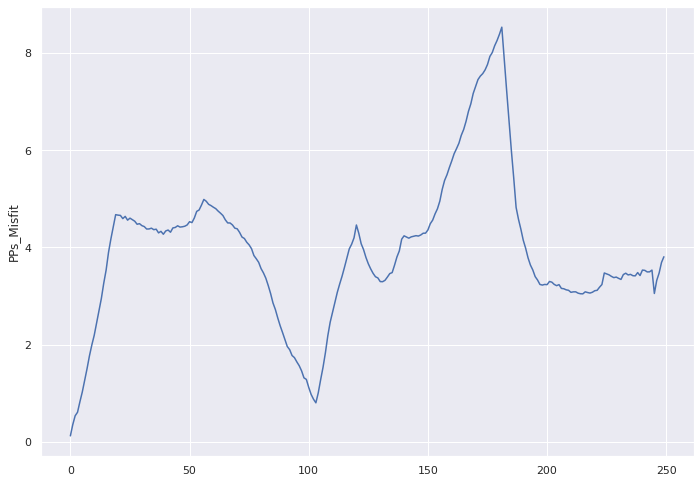

In [160]:
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['PPs_Misfit'] * 180 / np.pi)

<AxesSubplot:ylabel='Point0'>

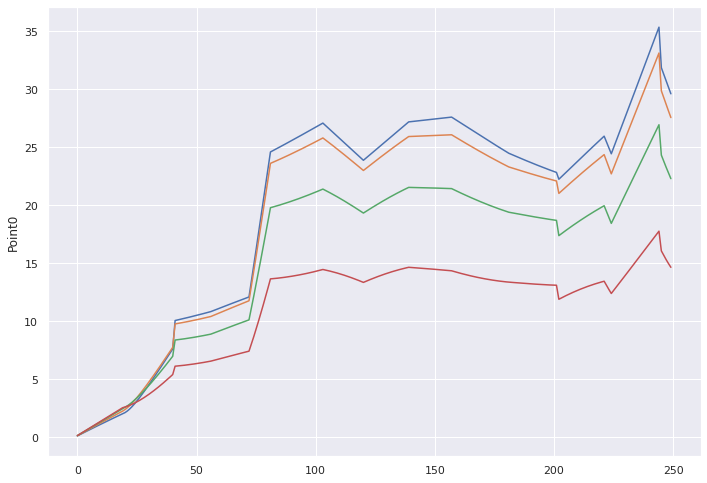

In [179]:
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['Point0'] * 180 / np.pi)
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['Point20'] * 180 / np.pi)
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['Point40'] * 180 / np.pi)
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['Point60'] * 180 / np.pi)

<AxesSubplot:ylabel='TR_Misfit'>

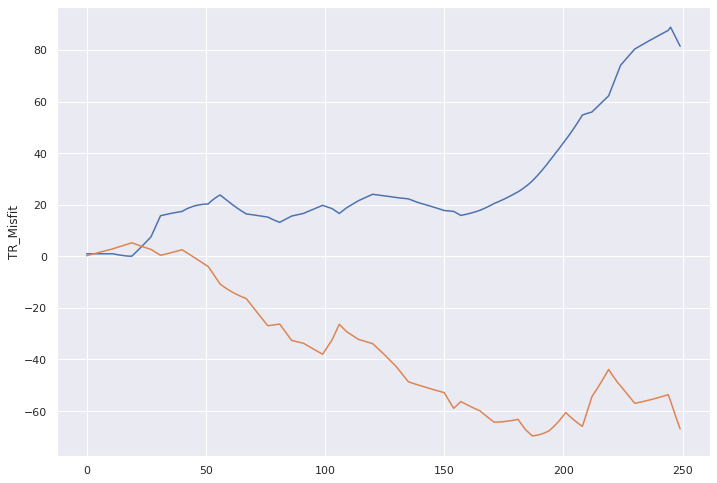

In [162]:
#sns.lineplot( x =  apwp_complete.index, y = apwp_complete['TR_Misfit'] * 180 / np.pi)
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['TR_Misfit'] * 180 / np.pi)
sns.lineplot( x =  apwp_complete.index, y = apwp_complete['TR_Ang_Misfit'] * 180 / np.pi)

#### Geodetic distance between the total reconstruction 

In [39]:
ind = 100
tr200 = rotation.from_rotvec(apwp_complete.iloc[ind].TR_omega * np.array([apwp_complete.iloc[ind].TR_x, apwp_complete.iloc[ind].TR_y, apwp_complete.iloc[ind].TR_z]))
tr200.apply(np.array([0,0,-1]))

GCD_cartesian([apwp_complete.iloc[ind].TR_x, apwp_complete.iloc[ind].TR_y, apwp_complete.iloc[ind].TR_z],[apwp_complete.iloc[ind].TR_x_inv, apwp_complete.iloc[ind].TR_y_inv, apwp_complete.iloc[ind].TR_z_inv])*180/np.pi

5.457124454084523